In [1]:
import pandas as pd
import torch
import transformers

from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    DataCollatorWithPadding
)
import numpy as np
from evaluate import load
import os

from dataloader import DataLoader
from trainer import CustomTrainer

torch.cuda.empty_cache()
# torch.set_num_threads(2)

import matplotlib.pyplot as plt

/vol/bitbucket/hrm20/dlenv2/lib/python3.12/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
os.environ["WANDB_MODE"] = "disabled"  # Disable wandb logging
os.environ["WANDB_DISABLED"] = "true"  # Fully disable wandb

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "prajjwal1/bert-tiny"
dataset_name = "multi_nli"

data_loader = DataLoader(dataset_name, model_name)
train_dataset, eval_dataset, tokenizer, num_labels = data_loader.prepare_datasets()

Using device: cuda


In [5]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3  # MNLI has 3 classes: entailment, contradiction, neutral
)
model.to(device)

# Load accuracy metric
metric = load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Training arguments
training_args = TrainingArguments(
    output_dir="bert-tiny-mnli",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    logging_steps=500,
    logging_first_step=True,
)

# Initialise trainer and train
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    methods=["loss", "forgetting"]
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/vol/bitbucket/hrm20/dlenv2/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/vol/bitbucket/hrm20/fyp/trainer.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.855200,0.833949,0.626592



Epoch 1 Summary:
Average Loss: 0.9052


TrainOutput(global_step=24544, training_loss=0.9051880672418621, metrics={'train_runtime': 369.5832, 'train_samples_per_second': 1062.554, 'train_steps_per_second': 66.41, 'total_flos': 124769606168064.0, 'train_loss': 0.9051880672418621, 'epoch': 1.0})

In [6]:
forgetting_results = trainer.get_unified_stats()['forgetting_stats']['forgetting_events']
forgetting_results

{0: 0,
 1: -1,
 2: -1,
 3: 1,
 4: 1,
 5: 1,
 6: -1,
 7: 0,
 8: 0,
 9: -1,
 10: 0,
 11: 0,
 12: 0,
 13: -1,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: -1,
 19: -1,
 20: 0,
 21: 0,
 22: 0,
 23: -1,
 24: -1,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: -1,
 31: 1,
 32: 0,
 33: 0,
 34: -1,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: -1,
 41: 0,
 42: -1,
 43: 0,
 44: 0,
 45: -1,
 46: 0,
 47: -1,
 48: 1,
 49: 0,
 50: 1,
 51: -1,
 52: 0,
 53: 1,
 54: 0,
 55: 0,
 56: -1,
 57: 1,
 58: -1,
 59: 0,
 60: 0,
 61: -1,
 62: 0,
 63: 1,
 64: 0,
 65: 0,
 66: 0,
 67: -1,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: -1,
 75: 0,
 76: 0,
 77: -1,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: -1,
 86: 0,
 87: -1,
 88: -1,
 89: -1,
 90: -1,
 91: 0,
 92: 0,
 93: 1,
 94: -1,
 95: 1,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: -1,
 101: -1,
 102: 1,
 103: -1,
 104: 0,
 105: 0,
 106: 0,
 107: -1,
 108: 0,
 109: 0,
 110: -1,
 111: -1,
 112: 0,
 113: 0,
 114: 0,
 115: 0,
 116: 0,
 117: 0,
 118: -1,
 119

In [7]:
loss = trainer.get_unified_stats()['loss_stats']['epoch_losses']
epoch_losses = loss

[0.9051865339442206]

In [ ]:
# Count freqs of forgetting events
forgetting_counts = {}
for value in forgetting_results.values():
    if value not in forgetting_counts:
        forgetting_counts[value] = 0
    forgetting_counts[value] += 1

# Separate not-learned from other labels
forgetting_keys = sorted([k for k in forgetting_counts.keys() if k != -1])
forgetting_labels = forgetting_keys + ["Not Learned"]

total_samples = len(train_dataset)

# Calculate percentages
forgetting_values = [forgetting_counts[k] / total_samples * 100 for k in forgetting_keys]
forgetting_values.append(forgetting_counts[-1] / total_samples * 100)

# Plot chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(forgetting_labels)), forgetting_values, color='gray')

plt.xticks(range(len(forgetting_labels)), forgetting_labels)
plt.xlabel("Forgetting Events")
plt.ylabel("Number of Samples")
plt.title("Forgetting Events Bar Chart")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


NameError: name 'total_samples' is not defined

In [18]:
print(forgetting_counts)

{0: 248407, 1: 88329, -1: 55966}


In [20]:
trainer.get_unified_stats()['loss_stats']['per_sample_average_losses']

{0: 0.7816128532091776,
 1: 1.3945470452308655,
 2: 0.5935519536336263,
 3: 0.5503620157639185,
 4: 0.4929099380970001,
 5: 0.6472083727518717,
 6: 0.7470598419507345,
 7: 0.9501868883768717,
 8: 0.5706789294878641,
 9: 1.4526808659235637,
 10: 0.6075892249743143,
 11: 0.9105101823806763,
 12: 0.6071075598398844,
 13: 0.7204776555299759,
 14: 1.2417772710323334,
 15: 0.35829364508390427,
 16: 1.2316008806228638,
 17: 0.45336681107680005,
 18: 1.052302062511444,
 19: 1.2862967650095622,
 20: 1.224001829822858,
 21: 0.600594791273276,
 22: 0.5486455460389456,
 23: 0.6413708304365476,
 24: 1.4356537262598674,
 25: 0.47032175461451214,
 26: 1.1866112351417542,
 27: 1.1550536354382832,
 28: 0.963044802347819,
 29: 0.5795184026161829,
 30: 1.4528400301933289,
 31: 1.1241582036018372,
 32: 0.6246364315350851,
 33: 0.4083593587080638,
 34: 1.418522298336029,
 35: 0.9616119066874186,
 36: 0.746324380238851,
 37: 0.8749786218007406,
 38: 0.6200979749361674,
 39: 1.2490939994653065,
 40: 1.134720

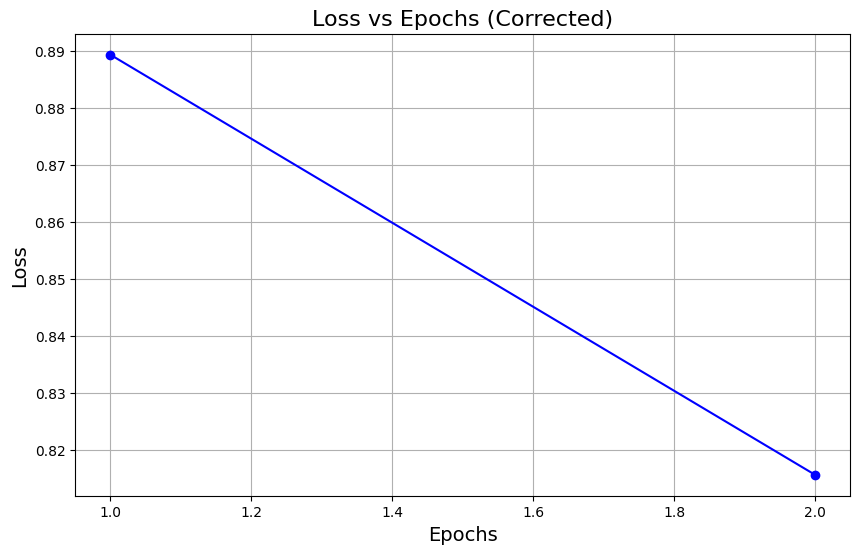

[0.88930662588423, 0.8157171660775547]


In [ ]:
# Plot the average loss per epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-', color='b')

plt.title("Loss vs Epochs", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)

plt.show()
print(epoch_losses)